In [30]:
# first some initial setup of libraries we will be using
import pandas as pd # this is the main library used in python for manipulating data. 
import json # this is a library to parse json (javascript object notation)
from urllib.request import urlopen # library to read data from a URL
import matplotlib.pyplot as plt # visualization library we will use that integrates with pandas
import requests
from bs4 import BeautifulSoup
import re
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
# We are reading in the data we want from ACS 2021. The API returns json data. Try copy and pasting the link yourself in a browser to see what the raw data looks like.
url="https://api.census.gov/data/2021/acs/acs1?get=NAME,B19001_001E,B19001_002E,B19001_017E&for=congressional%20district:*&in=state:*"

# store the response of URL
response = urlopen(url)

# storing the JSON response from url in data
data_json = json.loads(response.read())
data_json.pop(0) # the first row of data is header information which we don't need, so pop removes that from the dataset.

# Hand populate the columns based on the variable descriptions census.gov documents here: https://api.census.gov/data/2021/acs/acs1/variables.html. Note they correspond back to the variable names I included in the URL above.
cols = ['District Name','Total Households','Less than $10k', '$200k+', 'State code', 'district number']

acs_df = pd.DataFrame(data_json, columns = cols)

# time to do some basic cleanup of the data. We will need to extract the district number and state in a regular format so we can later join with the party data.
acs_df[['District', 'State']] = acs_df['District Name'].str.split(',', expand=True)
acs_df['district number'] = pd.to_numeric(acs_df['district number'])

acs_df['State'] = acs_df['State'].str.strip()

# Let's just keep the columns we need
acs_df = acs_df[['Total Households', 'Less than $10k', "$200k+", 'district number', 'State']]

# take a look at the top results in the dataset
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State
0,289474,14153,19390,10,Michigan
1,299804,23793,10899,4,Mississippi
2,278057,27728,19574,14,Michigan
3,306685,19036,12208,1,Michigan
4,285554,26481,12412,3,Mississippi


In [32]:
# Convert the number columns into number data types so we can math on them
acs_df["Total Households"] = pd.to_numeric(acs_df["Total Households"])
acs_df["Less than $10k"] = pd.to_numeric(acs_df["Less than $10k"])
acs_df['$200k+'] = pd.to_numeric(acs_df['$200k+'])

# Compute some new columns based on the existing columns for later visualization
acs_df['% of households over $200k'] = (100*acs_df['$200k+'])/acs_df['Total Households']
acs_df['% of households less than $10k'] = (100*acs_df['Less than $10k'])/acs_df['Total Households']

# now let's look at the data again
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k
0,289474,14153,19390,10,Michigan,6.698356,4.889213
1,299804,23793,10899,4,Mississippi,3.635375,7.936185
2,278057,27728,19574,14,Michigan,7.039564,9.972056
3,306685,19036,12208,1,Michigan,3.980632,6.207020
4,285554,26481,12412,3,Mississippi,4.346638,9.273552


In order to find the number of metropolitan and micropolitan cities per state, we scrape data from www.citypopulation.de

In [33]:
url = "https://www.citypopulation.de/en/usa/metro/"
data = requests.get(url).text

soup = BeautifulSoup(data, 'html.parser')
tables = soup.find_all('td')

In [34]:
# Create function to remove html from the extracted strings
CLEANR = re.compile('<.*?>') 
def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

cleanhtml(str(tables[1]))
clean_values = []
for i in tables:
  clean_values.append(cleanhtml(str(i)))
clean_values[0:20]

['Aberdeen',
 'Micropolitan Statistical Area',
 'SD',
 '39,936',
 '39,827',
 '40,602',
 '42,287',
 '42,134',
 '→',
 'Aberdeen',
 'Micropolitan Statistical Area',
 'WA',
 '64,175',
 '67,194',
 '72,797',
 '75,636',
 '76,841',
 '→',
 'Abilene',
 'Metropolitan Statistical Area']

In [35]:
# Remove all the arrows in the list
ele='→'
clean_values=[i for i in clean_values if i!=ele]
clean_values[0:20]

['Aberdeen',
 'Micropolitan Statistical Area',
 'SD',
 '39,936',
 '39,827',
 '40,602',
 '42,287',
 '42,134',
 'Aberdeen',
 'Micropolitan Statistical Area',
 'WA',
 '64,175',
 '67,194',
 '72,797',
 '75,636',
 '76,841',
 'Abilene',
 'Metropolitan Statistical Area',
 'TX',
 '148,004']

In [36]:
# Convert the list of values into a dataframe

df = [] 
rows = [] 
for i in clean_values:
  if len(rows)!=7:
    rows.append(i)
  else:
    df.append(rows)
    rows = []
df2 = pd.DataFrame(df, columns = ['City', 'Status','State','2000','2010','2020','2021'])  
df2.head()   

,City,Status,State,2000,2010,2020,2021
0,Aberdeen,Micropolitan Statistical Area,SD,"39,936","39,827","40,602","42,287"
1,Aberdeen,Micropolitan Statistical Area,WA,"64,175","67,194","72,797","75,636"
2,Abilene,Metropolitan Statistical Area,TX,"148,004","160,245","165,252","176,579"
3,Ada,Micropolitan Statistical Area,OK,"34,119","35,143","37,492","38,065"
4,Adrian,Micropolitan Statistical Area,MI,"91,476","98,890","99,892","99,423"


Exploring the scraped data:

In [37]:
# Checking number of distinct states
df2['State'].nunique()

101

In [38]:
# Checking why there are 101 unique states
pd.set_option('max_rows', 1000)
df2['State'].value_counts()

TX             70
OH             40
NC             36
IN             36
CA             34
GA             34
PA             33
MI             30
FL             29
NY             26
AL             24
IL             24
TN             23
MS             21
MO             21
OK             21
WI             21
MN             20
AR             20
WA             20
KS             19
IA             19
KY             19
NM             19
LA             18
OR             18
CO             17
SC             15
PR             12
ID             12
SD             11
AZ             11
NE             11
VA             10
NV              9
WV              8
UT              8
WY              8
MT              7
CT              5
NH              5
ND              5
AK              4
NJ              4
HI              4
ME              4
VT              4
MD              4
MA              4
ND-MN           3
WV-OH           3
MD-WV           2
GA-AL           2
MN-WI           2
MO-IL           2
IA-IL     

In [39]:
## Checking why one city would have two different states

df2.loc[df2['State'] == "ND-MN"]

,City,Status,State,2000,2010,2020,2021
282,Fargo,Metropolitan Statistical Area,ND-MN,"153,296","174,367","208,777","249,843"
333,Grand Forks,Metropolitan Statistical Area,ND-MN,"103,181","97,478","98,461","104,362"
887,Wahpeton,Micropolitan Statistical Area,ND-MN,"25,664","25,136","22,897","23,035"


In [40]:
# Removing all rows that have two states
discard = ["-"]
dataframe1 = df2[~df2['State'].str.contains('|'.join(discard))]
dataframe1['State'].nunique()

50

Cleaning the data before joining with the original dataframe:

In [41]:
# Creating a new column with the spelled out state names in order to join with the original dataset

states = {"AL":"Alabama", "AK":"Alaska", "AZ":"Arizona", "AR":"Arkansas", "CA":"California", "CO":"Colorado", "CT":"Connecticut", 
          "DC":"Washington DC", "DE":"Delaware", "FL":"Florida", "GA":"Georgia", "HI":"Hawaii", "ID":"Idaho", "IL":"Illinois", 
          "IN":"Indiana", "IA":"Iowa", "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine", "MD":"Maryland",
          "MA":"Massachusetts", "MI":"Michigan", "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana",
          "NE":"Nebraska", "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey", "NM":"New Mexico", "NY":"New York", 
          "NC":"North Carolina", "ND":"North Dakota", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon", "PA":"Pennsylvania", 
          "RI":"Rhode Island", "SC":"South Carolina", "SD":"South Dakota", "TN":"Tennessee", "TX":"Texas", "UT":"Utah", "VT":"Vermont",
          "VA":"Virginia", "WA":"Washington", "WV":"West Virginia","WI":"Wisconsin", "WY":"Wyoming"}
 
dataframe1["State_Name"] = dataframe1.State.map(states)
dataframe1['State_Name'].value_counts()

<ipython-input-41-e96f8aabac5b>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Texas             70
Ohio              40
Indiana           36
North Carolina    36
Georgia           34
California        34
Pennsylvania      33
Michigan          30
Florida           29
New York          26
Alabama           24
Illinois          24
Tennessee         23
Wisconsin         21
Mississippi       21
Oklahoma          21
Missouri          21
Washington        20
Arkansas          20
Minnesota         20
Kansas            19
Iowa              19
New Mexico        19
Kentucky          19
Louisiana         18
Oregon            18
Colorado          17
South Carolina    15
Idaho             12
Arizona           11
Nebraska          11
South Dakota      11
Virginia          10
Nevada             9
West Virginia      8
Wyoming            8
Utah               8
Montana            7
Connecticut        5
New Hampshire      5
North Dakota       5
Maine              4
Vermont            4
Massachusetts      4
Maryland           4
New Jersey         4
Alaska             4
Hawaii       

In [42]:
dataframe1.head()

,City,Status,State,2000,2010,2020,2021,State_Name
0,Aberdeen,Micropolitan Statistical Area,SD,"39,936","39,827","40,602","42,287",South Dakota
1,Aberdeen,Micropolitan Statistical Area,WA,"64,175","67,194","72,797","75,636",Washington
2,Abilene,Metropolitan Statistical Area,TX,"148,004","160,245","165,252","176,579",Texas
3,Ada,Micropolitan Statistical Area,OK,"34,119","35,143","37,492","38,065",Oklahoma
4,Adrian,Micropolitan Statistical Area,MI,"91,476","98,890","99,892","99,423",Michigan


In [43]:
# Using groupby to collapse the dataframe
area_count = pd.DataFrame({'Count' : dataframe1.groupby( [ "State_Name", "Status"] ).size()}).reset_index()
area_count


,State_Name,Status,Count
0,Alabama,Metropolitan Statistical Area,12
1,Alabama,Micropolitan Statistical Area,12
2,Alaska,Metropolitan Statistical Area,2
3,Alaska,Micropolitan Statistical Area,2
4,Arizona,Metropolitan Statistical Area,7
5,Arizona,Micropolitan Statistical Area,4
6,Arkansas,Metropolitan Statistical Area,5
7,Arkansas,Micropolitan Statistical Area,15
8,California,Metropolitan Statistical Area,26
9,California,Micropolitan Statistical Area,8


In [44]:
# Showing Frequencies of Metropolitan and Micropolitan Areas in each state

piv_count = (area_count.pivot(index=['State_Name'],columns=["Status"], values="Count")
         .sort_index(level=[1,0]))

piv_count['Metropolitan Statistical Area'] = piv_count['Metropolitan Statistical Area'].astype('int')
piv_count['Micropolitan Statistical Area'] = piv_count['Micropolitan Statistical Area'].fillna(0)
piv_count['Micropolitan Statistical Area'] = piv_count['Micropolitan Statistical Area'].astype('int')

piv_count = piv_count.rename(columns={"State_Name" : "State Name", "Metropolitan Statistical Area" : "Metro Count",
                   "Micropolitan Statistical Area" : "Micro Count"})

piv_count = piv_count.reset_index()

piv_count.head()



Status,State_Name,Metro Count,Micro Count
0,Alabama,12,12
1,Alaska,2,2
2,Arizona,7,4
3,Arkansas,5,15
4,California,26,8


In [45]:
# Removing districts that are not in the scraped data

discard = ["Puerto", "Rhode", "Columbia"]
piv_count = piv_count[~piv_count['State_Name'].str.contains('|'.join(discard))]
piv_count['State_Name'].nunique()

49

Feature Engineering:

In [46]:
# Calculating the % metropolitan and micropolitan cities per state

piv_count['% Metro'] = (piv_count['Metro Count'] / (piv_count['Metro Count'] + piv_count['Micro Count'])) *100 
piv_count['% Micro'] = (piv_count['Micro Count'] / (piv_count['Metro Count'] + piv_count['Micro Count'])) *100 

piv_count['% Metro'] = piv_count['% Metro'].round(decimals=2)
piv_count['% Micro'] = piv_count['% Micro'].round(decimals=2)

piv_count.head()

Status,State_Name,Metro Count,Micro Count,% Metro,% Micro
0,Alabama,12,12,50.00,50.00
1,Alaska,2,2,50.00,50.00
2,Arizona,7,4,63.64,36.36
3,Arkansas,5,15,25.00,75.00
4,California,26,8,76.47,23.53


In [47]:
# Checking the original data
acs_df.head()

,Total Households,Less than $10k,$200k+,district number,State,% of households over $200k,% of households less than $10k
0,289474,14153,19390,10,Michigan,6.698356,4.889213
1,299804,23793,10899,4,Mississippi,3.635375,7.936185
2,278057,27728,19574,14,Michigan,7.039564,9.972056
3,306685,19036,12208,1,Michigan,3.980632,6.207020
4,285554,26481,12412,3,Mississippi,4.346638,9.273552


In [48]:
# Performing a left join on the original data
data2 = (acs_df.groupby(['State'], as_index=False).mean()
            .groupby('State')['% of households over $200k', '% of households less than $10k'].mean().reset_index())

final_df = data2.rename(columns={"% of households over $200k" : "% over 200k",
                   "% of households less than $10k" : "% under 10k"})

final_df['% over 200k'] = final_df['% over 200k'].round(decimals=2)
final_df['% under 10k'] = final_df['% under 10k'].round(decimals=2)

final_df.head()

<ipython-input-48-f9c1eeb62e04>:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,State,% over 200k,% under 10k
0,Alabama,5.10,7.80
1,Alaska,10.21,5.39
2,Arizona,7.86,5.76
3,Arkansas,4.60,7.67
4,California,14.92,5.34


In [49]:
final_df = final_df.set_index('State').join(piv_count.set_index('State_Name'), on='State')
final_df = final_df.reset_index()
final_df.head()

,State,% over 200k,% under 10k,Metro Count,Micro Count,% Metro,% Micro
0,Alabama,5.10,7.80,12.0,12.0,50.00,50.00
1,Alaska,10.21,5.39,2.0,2.0,50.00,50.00
2,Arizona,7.86,5.76,7.0,4.0,63.64,36.36
3,Arkansas,4.60,7.67,5.0,15.0,25.00,75.00
4,California,14.92,5.34,26.0,8.0,76.47,23.53


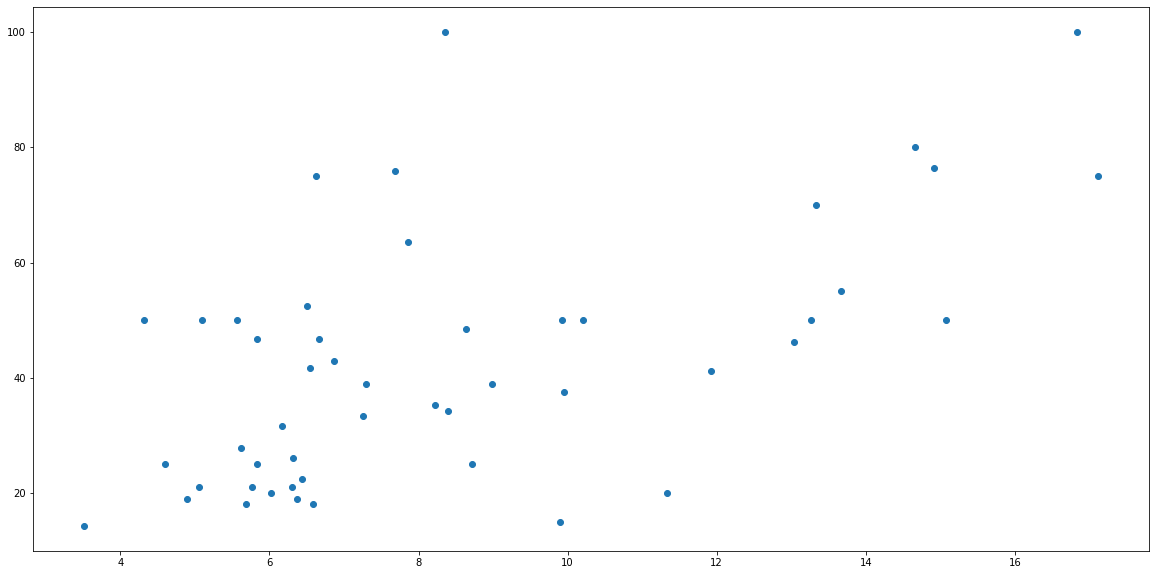

In [57]:
# % of metropolitan cities vs households that cost over 200k per state
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(final_df['% over 200k'], final_df['% Metro'])

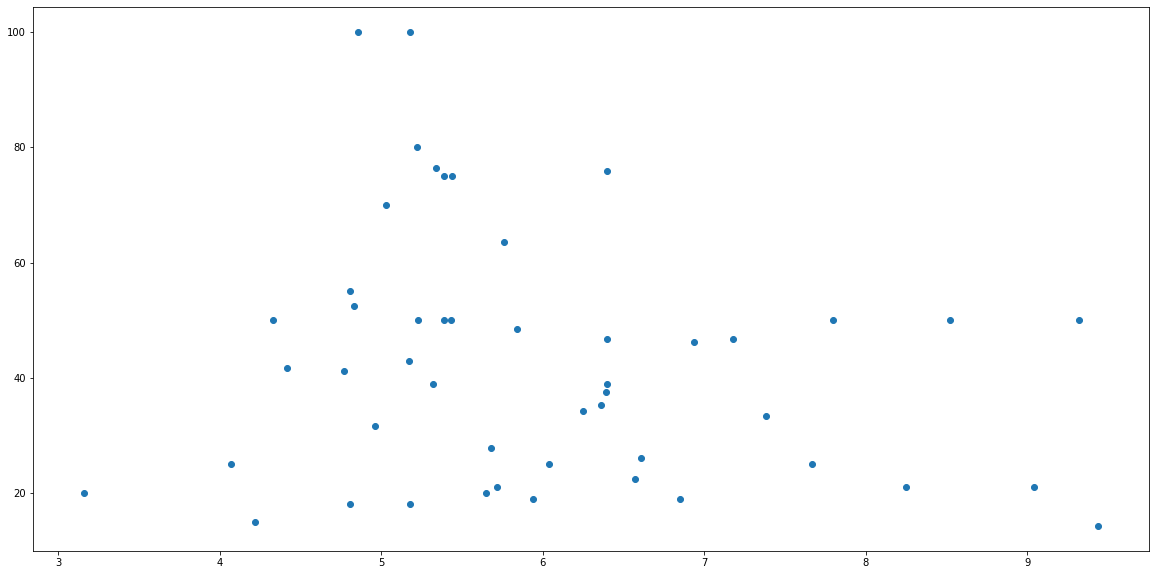

In [59]:
# % of metropolitan cities vs households that cost under 10k per state

plt.scatter(final_df['% under 10k'], final_df['% Metro'])